# Entity Sentiment Model Analysis
By Ganel R. Nallamilli
***

This notebook provides a comprehensive analysis of entity sentiment using machine learning models. It leverages datasets from Kaggle to perform sentiment analysis on financial news and Twitter data. The primary objective is to identify and analyze the sentiment associated with specific entities mentioned in the text.

# Introduction

Entity sentiment analysis is a crucial task in natural language processing (NLP) that focuses on determining the sentiment expressed about specific entities, such as companies, individuals, or products, within a text. This analysis is particularly valuable in finance, where understanding market sentiment can provide insights into stock performance, investment opportunities, and public opinion.

In this notebook, we will explore entity sentiment using two datasets from Kaggle. The goal is to develop a model that can accurately predict the sentiment associated with entities mentioned in the text. We will begin by exploring the datasets, followed by building and evaluating machine learning models.

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW
import torch.nn as nn
import ast
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Datasets

## 3.1 Dataset Overview

This analysis uses two datasets from Kaggle:
1. [Aspect-Based Sentiment Analysis for Financial News](https://www.kaggle.com/datasets/ankurzing/aspect-based-sentiment-analysis-for-financial-news): This dataset contains financial news articles with labeled sentiment for various entities.
2. [Twitter Entity Sentiment Analysis](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis): This dataset includes tweets with sentiment labels for entities mentioned in the text.

Both datasets are pre-processed to ensure they are suitable for model training and evaluation.

## 3.2 Data Loading

In this section, we will load the datasets into the notebook and perform any necessary preprocessing steps. This includes handling missing values, and ensuring the data is in the correct format for modeling. Our end goal is to merge both datasets into a single dataframe with headers, 'title', 'entities' and 'sentiments'.

In [22]:
data_fin = pd.read_csv('SEntFiN-v1.1.csv')
data_twitter_train = pd.read_csv('twitter_training.csv', names = ['tweet_ID','entity','sentiment','titles'])
data_twitter_test = pd.read_csv('twitter_validation.csv', names = ['tweet_ID','entity','sentiment','titles'])

display(data_fin.head())
display(data_twitter_train.head())
display(data_twitter_test.head())

,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8


,tweet_ID,entity,sentiment,titles
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


,tweet_ID,entity,sentiment,titles
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


### Preparing the Finanical Sentiment Dataset
Our first step is to convert the dictionary of entities which is a string, to an actual python dictionary.

In [23]:
print(f"The current type for the dictionary is: {type(data_fin['Decisions'].iloc[0])}")
Decisions_arr = [ast.literal_eval(data_fin['Decisions'].iloc[i]) for i in range(len(data_fin['Decisions']))]
data_fin['Decisions'] = Decisions_arr
display(data_fin.head())
print(f"The current type for the dictionary is: {type(data_fin['Decisions'].iloc[0])}")

The current type for the dictionary is: <class 'str'>


,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,{'SpiceJet': 'neutral'},8
1,2,MMTC Q2 net loss at Rs 10.4 crore,{'MMTC': 'neutral'},8
2,3,"Mid-cap funds can deliver more, stay put: Experts",{'Mid-cap funds': 'positive'},8
3,4,Mid caps now turn into market darlings,{'Mid caps': 'positive'},7
4,5,"Market seeing patience, if not conviction: Pra...",{'Market': 'neutral'},8


The current type for the dictionary is: <class 'dict'>


The fin sentiment dataset has multiple entities for one title. This will be an issue in how we want our model to handle this data, so we add duplicate titles such that each title is associated with one entity and it's assoicated sentiment.

In [24]:
titles = []
entities = []
sentiments = []

for i in range(len(data_fin['Title'])):
  title = data_fin['Title'].iloc[i]

  for entity, sentiment in data_fin['Decisions'].iloc[i].items():
    titles.append(title)
    entities.append(entity)
    sentiments.append(sentiment)

Now we combine the titles, entities, sentiments into one dataframe, along with mapping the sentiments (which are currently words) to numbers...

- Positive -> 0
- Neutral -> 1
- Negative -> 2

In [25]:
data_fin = pd.DataFrame({'titles':titles,'entities':entities,'sentiments':sentiments})
sentiment_to_label = {'positive': 0, 'neutral': 1, 'negative': 2}
data_fin['sentiments'] = data_fin['sentiments'].map(sentiment_to_label)
display(data_fin)

,titles,entities,sentiments
0,SpiceJet to issue 6.4 crore warrants to promoters,SpiceJet,1
1,MMTC Q2 net loss at Rs 10.4 crore,MMTC,1
2,"Mid-cap funds can deliver more, stay put: Experts",Mid-cap funds,0
3,Mid caps now turn into market darlings,Mid caps,0
4,"Market seeing patience, if not conviction: Pra...",Market,1
...,...,...,...
14404,Rupee slips against US dollar,US dollar,1
14405,Rupee weak against US dollar,Rupee,2
14406,Rupee weak against US dollar,US dollar,1
14407,Australia shares flat; energy drags,Australia shares,1


### Preparing the Twitter Sentiment Dataset
The next step is to prepare the twitter dataset into a dataset resembling the, title, entities and sentiments format. Luckily, the dataset is already in a similar dataset, so we just have to merge the training and validation as we will split the data ourselves, then encode the sentiments.

In [26]:
data_twitter = pd.concat([data_twitter_train,data_twitter_test],axis=0).dropna()
data_twitter['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

The twitter dataset has an extra sentiment 'Irrelevant', so we will filter this out and then perform our encoding.

In [27]:
data_twitter = data_twitter[data_twitter['sentiment'] != 'Irrelevant']
# Encode sentiment labels
sentiment_to_label = {'Positive': 0, 'Neutral': 1, 'Negative': 2}
data_twitter['sentiment'] = data_twitter['sentiment'].map(sentiment_to_label)
data_twitter = pd.DataFrame({'titles': data_twitter['titles'].to_list(),'entities': data_twitter['entity'].to_list(),'sentiments': data_twitter['sentiment'].to_list()})


### Merging the Datasets
With both datasets prepared in a similar manner we can now merged them. I note that the language used in twitter is generally less formal than language used looking at financial headlines, however I have decided that having more data for the model to learn about entity-sentiment relations is more important than using a smaller dataset with more formal language.

In [28]:
dataset = pd.concat([data_fin, data_twitter], axis=0)
display(dataset)

,titles,entities,sentiments
0,SpiceJet to issue 6.4 crore warrants to promoters,SpiceJet,1
1,MMTC Q2 net loss at Rs 10.4 crore,MMTC,1
2,"Mid-cap funds can deliver more, stay put: Experts",Mid-cap funds,0
3,Mid caps now turn into market darlings,Mid caps,0
4,"Market seeing patience, if not conviction: Pra...",Market,1
...,...,...,...
61944,Please explain how this is possible! How can t...,Amazon,2
61945,Good on Sony. As much as I want to see the new...,PlayStation5(PS5),0
61946,Today sucked so it’s time to drink wine n play...,Borderlands,0
61947,Bought a fraction of Microsoft today. Small wins.,Microsoft,0


## Exploratory Data Analysis (EDA)

### 4.1 Data Inspection

Before diving into modeling, it's essential to understand the structure and content of our datasets. We will start by inspecting the data, looking for missing values, and analyzing the distribution of sentiments across the datasets. This will help us identify any potential issues or biases in the data.


In [29]:
# Check for missing values in the datasets
print(dataset.isnull().sum())

titles        0
entities      0
sentiments    0
dtype: int64


No missing data, fantastic!

### 4.2 Visualization

To gain further insights, we will visualize the data. This includes plotting the distribution of sentiments, examining the frequency of different entities, and any other relevant features. Visualizations can provide a clearer understanding of patterns and trends within the data, which will inform our modeling decisions.


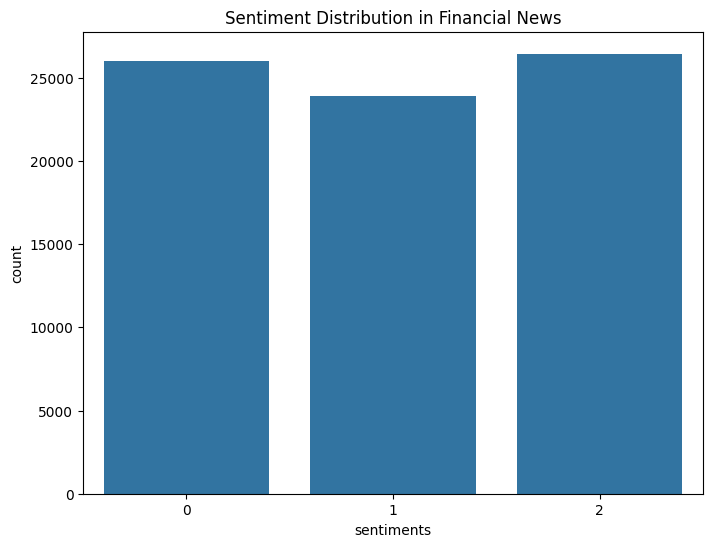

sentiments
2    26443
0    26007
1    23908
Name: count, dtype: int64

In [30]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiments', data=dataset)
plt.title('Sentiment Distribution in Financial News')
plt.show()
dataset_sentiment_distribution = dataset['sentiments'].value_counts()
display(dataset_sentiment_distribution)

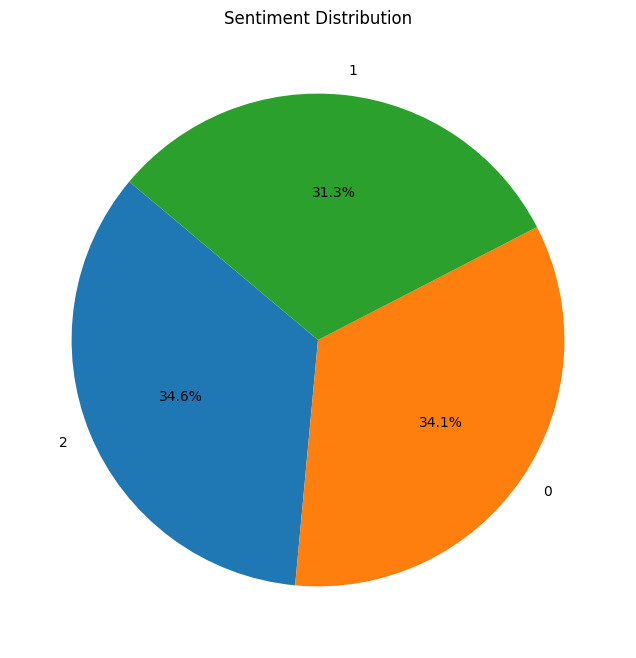

In [31]:
# Calculate the distribution of sentiment in the financial news dataset
dataset_sentiment_distribution = dataset['sentiments'].value_counts()

# Plot the pie chart for the financial news dataset
plt.figure(figsize=(8, 8))
plt.pie(dataset_sentiment_distribution, labels=dataset_sentiment_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.show()

We see that the dataset is fairly evenly split between all 3 sentiment classes which means we don't have to worry about our model being bias towards a dataset.

## Train/Validation/Test Split
We now can split the data into training, validation and testing datasets...

In [32]:
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

display(train_data.tail())
display(val_data.tail())
display(test_data.tail())

,titles,entities,sentiments
7688,NSE to conduct 75-minute 'Muhurat Trading' on ...,NSE,1
32263,"4x Nozdormu the Timeless! X] Sadly, it was jus...",Hearthstone,0
21477,I love how sexuality is articulated in assassi...,AssassinsCreed,0
61156,Our eldest has spent so long playing this new ...,CallOfDuty,0
9441,Elections may provide a short-term market boos...,JPMorgan,1


,titles,entities,sentiments
13208,South Korean shares reverse early gains to clo...,won,2
14242,It turns out that black looks fiery,PlayStation5(PS5),0
51580,Or The characters Gordon and Saquon disrespect,MaddenNFL,2
14042,"Silver bounces back on global cues, gold also ...",gold,0
868,Waiting for Nifty to move above 5570-5575: Mit...,Nifty,1


,titles,entities,sentiments
36388,@verizon your TV commercials include men who h...,Verizon,2
47672,What the hell is facebook doing man pic.twitte...,Facebook,2
57930,This is how much I enjoy,TomClancysGhostRecon,0
7732,Reliance Industries Ltd shares end flat after ...,Reliance Industries Ltd,1
14496,Slim and clean,PlayStation5(PS5),0


# Model Development
## Custom Dataset Class (Tokenization)
In this section, we define a custom ```Dataset``` class, ```EntitySentimentDataset```, to handle the data preparation for our entity sentiment analysis model. This class is essential for converting our data into a format that can be fed into a PyTorch model.

Explanation:

- **\_\_init__**: Initializes the dataset with the data, tokenizer, and maximum length for tokenization.
- **\_\_len__**: Returns the length of the dataset.
- **\_\_getitem__**: Retrieves a single data item, tokenizes the entity and headline, and returns the input tensors required for the model.

In [33]:
class EntitySentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        headline = row['titles']
        entity = row['entities']
        sentiment = row['sentiments']

        inputs = self.tokenizer.encode_plus(
            entity,
            headline,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = inputs['input_ids'].flatten()
        attention_mask = inputs['attention_mask'].flatten()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }


## Model Definition - BERT-based Sentiment Analysis Model
In this section, we define the EntitySentimentModel class, which is a BERT-based model customized for our sentiment analysis task. The model takes tokenized input data and outputs a sentiment prediction.

Explanation:

- \_\_init__: Initializes the model with BERT and a dropout layer, followed by a linear layer for classification.
- forward: The forward pass of the model, which processes the input data through BERT, applies dropout, and outputs the sentiment predictions.

In [34]:
class EntitySentimentModel(nn.Module):
    def __init__(self, n_classes):
        super(EntitySentimentModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[1]
        output = self.drop(pooled_output)
        return self.out(output)

n_classes = 3
model = EntitySentimentModel(n_classes).to(device)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

## Loading Model (Optional)
As a warning this model takes a long time to train, it took me 12 hours, if you would like to use my model simply run the code below, along with the **Data Loaders** subsection and skip to the **Model Evaluation** section, otherwise skip this subsection, and go to the **Data Loaders** subsection (next subsection).

My model has an accuracy around 91%. If you would like to use my model, simply download it from here: [Google Drive](https://drive.google.com/drive/folders/1WSHzK9bkSFi3_NfE9TWQmEIuGhUkaPoF?usp=sharing) and make sure the files are within the same directory as the notebook (make sure you unzip the 'tokenizer_directory').

In [35]:
#Load a previous model if you have already trained one and are reusing the notebook or would like to load my model.
tokenizer = BertTokenizer.from_pretrained('tokenizer_directory')
state_dict = torch.load('entire_model_state_dict.pth', map_location=device)
model.load_state_dict(state_dict)
model = model.to(device)


D:\TEMP\ipykernel_25360\506084677.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('entire_model_state_dict.pth', map_location=device)


## Data Loaders
Here, we create data loaders for the training, validation, and test datasets. Data loaders are essential for efficiently feeding data into the model during training and evaluation.

In [36]:
max_len = 512
batch_size = 32
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_dataset = EntitySentimentDataset(train_data, tokenizer, max_len)
val_dataset = EntitySentimentDataset(val_data, tokenizer, max_len)
test_dataset = EntitySentimentDataset(test_data, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

D:\UserFiles\Projects\NLP_Scraper_stock_headlines\env\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## Model Training
This section covers the training loop for the model, where we train the model over multiple epochs, calculate the loss for both training and validation, and have included an early stopping procedure which stops training if the validation loss does not improve.

Explanation:

- **criterion:** The loss function, in this case, cross-entropy loss, which is suitable for multi-class classification.
- **optimizer:** The optimizer (AdamW) for updating model parameters.
- The training loop iterates through the data for a set number of epochs, calculating the loss and updating the model weights.
- The validation loop is performed after each epoch to check the model's performance on unseen data, with early stopping implemented based on validation loss.

In [ ]:
num_epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-10, correct_bias=False)
total_steps = len(train_loader) * num_epochs

epochs_with_no_improvements = 0
best_loss = float('infinity')
best_model = None
patience = 1

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch in train_loader_tqdm:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, sentiments)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=total_loss/(train_loader_tqdm.n+1))

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    model.eval()
    val_loss = 0
    val_loader_tqdm = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for batch in val_loader_tqdm:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, sentiments)
            val_loss += loss.item()
            val_loader_tqdm.set_postfix(val_loss=val_loss/(val_loader_tqdm.n+1))

    avg_val_loss = val_loss / len(val_loader)

    if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            epochs_with_no_improvements = 0
            best_model = model
    else:
        epochs_with_no_improvements += 1

    if epochs_with_no_improvements == patience:
            break


    print(f'Validation Loss: {avg_val_loss:.4f}')

## Model Evaluation
After training, we evaluate the model's performance on the test dataset to check its accuracy.

In [37]:
# Evaluation
model.eval()
correct = 0
total = 0

test_loader_tqdm = tqdm(test_loader, desc="Testing", leave=False)

with torch.no_grad():
    for batch in test_loader_tqdm:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs.data, 1)
        total += sentiments.size(0)
        correct += (predicted == sentiments).sum().item()
        test_loader_tqdm.set_postfix(accuracy=100 * correct / total)

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 91.64%


The model is evaluated on the test dataset, where we calculate the number of correct predictions and compute the overall accuracy of the model.

## Saving the Model and Tokenizer
Due to the long training times, make sure to save your trained model!

In [58]:
torch.save(model, 'entire_model_personal.pth')
tokenizer.save_pretrained('tokenizer_directory_personal')

('tokenizer_directory_personal\\tokenizer_config.json',
 'tokenizer_directory_personal\\special_tokens_map.json',
 'tokenizer_directory_personal\\vocab.txt',
 'tokenizer_directory_personal\\added_tokens.json')

## Inference
Now for the cool part! We can now test our model with our own sample inputs. Simply change the code below the comment '#Example usage' below, and test it out!

Explanation:

- The ```predict_sentiment``` function takes a headline and an entity, tokenizes the input, and then uses the trained model to predict the sentiment.
- The example usage demonstrates how to make predictions for specific entities within a headline.


In [18]:
sentiment_to_label = {0: 'positive', 1: 'neutral', 2: 'negative'}
def predict_sentiment(model, tokenizer, headline, entity, max_len):
  model.eval()
  inputs = tokenizer.encode_plus(
      entity,
      headline,
      add_special_tokens=True,
      max_length=max_len,
      padding='max_length',
      truncation=True,
      return_tensors='pt'
  )

  input_ids = inputs['input_ids'].to(device)
  attention_mask = inputs['attention_mask'].to(device)

  with torch.no_grad():
      output = model(input_ids, attention_mask)
      _, predicted = torch.max(output, 1)

  return sentiment_to_label[predicted.cpu().numpy()[0]]

# Example usage
headline = "Apple has increased profits, google hasn't"
entity = "Apple"
print(f'Entity {entity} Sentiment: {predict_sentiment(model, tokenizer, headline, entity, max_len)}')
entity = "Google"
print(f'Entity {entity} Sentiment: {predict_sentiment(model, tokenizer, headline, entity, max_len)}')

Entity Apple Sentiment: positive
Entity Google Sentiment: negative


# Conclusion
In this notebook, we successfully developed an entity sentiment analysis model using BERT, leveraging datasets from financial news and Twitter. The primary goal was to analyze the sentiment expressed towards specific entities mentioned in the text, which is particularly valuable in fields like finance where sentiment analysis can provide insights into market behavior and public opinion.

## Key Takeaways:
- **Data Preparation:** We began by exploring and preparing two datasets, ensuring they were in a suitable format for model training. This involved encoding sentiments and merging the datasets to create a comprehensive training set.
- **Custom Dataset and Model Architecture:** A custom PyTorch Dataset was implemented to handle the input data, and a BERT-based model architecture was developed for the task. The model was designed to understand and predict the sentiment associated with entities mentioned in headlines.
- **Training and Evaluation:** The model was trained over multiple epochs, with early stopping implemented to prevent overfitting. We used cross-entropy loss as our objective function and validated the model on a separate validation set to ensure generalization. The final evaluation on the test set demonstrated the model's ability to accurately predict sentiment.
- **Model Inference:** We also implemented a function to make predictions on new data, allowing us to assess the sentiment towards entities in any given text.
## Potential Improvements:
- **Fine-Tuning:** Further fine-tuning of hyperparameters or using more advanced techniques such as learning rate scheduling could yield better results.
Domain-Specific Models: Given that financial news and Twitter data may have different linguistic characteristics, separate models or a multi-task learning approach could be explored.
- **Domain-Specific Models:** Given that financial news and Twitter data may have different linguistic characteristics, separate models or a multi-task learning approach could be explored
## Future Work:
- **Explainability:** Adding interpretability features, such as attention visualization, could help in understanding how the model makes decisions, particularly in critical applications like finance.

This project demonstrated the application of BERT for sentiment analysis at the entity level, highlighting the potential of NLP in extracting valuable insights from unstructured text data. While the model shows promising results, there are always opportunities for refinement and further exploration.

